# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.\
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [24]:
!pip install catboost

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import lightgbm as lgb

import seaborn as sns

## Загрузка данных

In [26]:
try:
  df = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
except:
  df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [27]:
#сортировка и ресемплирование данных по часу
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [28]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [30]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


После получения данных, они были ресемплированы в интервале по 1 часу\
По итогу получилось 4416 строк данных.\
Со средним в 84 заказа в час, и медианным значением в 78 заказов.

## Анализ данных

In [31]:
df['rolling_mean'] = df.rolling(10).mean()
df.head(10)

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
2018-03-01 05:00:00,6,NaN
2018-03-01 06:00:00,12,NaN
2018-03-01 07:00:00,15,NaN
2018-03-01 08:00:00,34,NaN


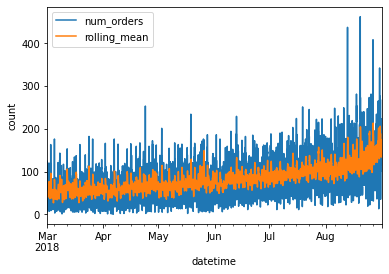

In [32]:
df.plot()
plt.ylabel('count')
plt.xlabel('datetime')
plt.title('График исходного количества заказов и скользящего среднего по ним')
plt.show()

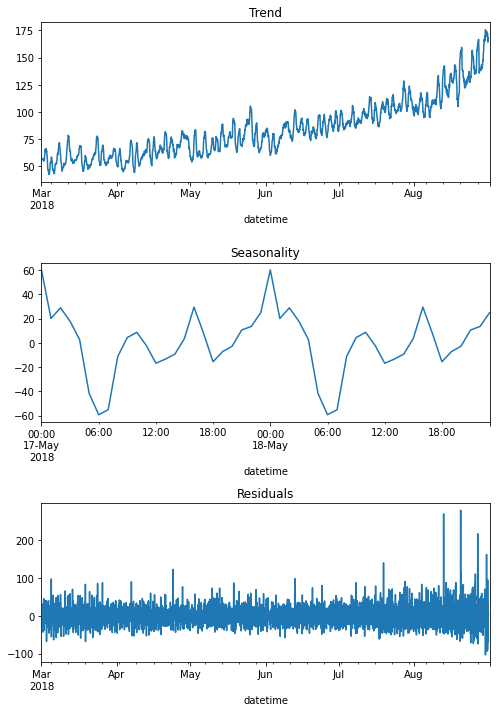

In [33]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(7, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-05-17':'2018-05-18'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- По полученым графикам можно увидеть общий тренд на повышение заказов
- Ближе к полуночи количество заказов увеличивается и достигает своего пика
- К 6 утра же наоборот, кол-во заказов уменьшается, в связи с тем, что начинает\
ходить общественный транспорт

### Создание признаков

In [34]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [35]:
make_features(df, 500, 100)

In [36]:
df.tail(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 14:00:00,133,155.85,2018,8,31,4,166.0,136.0,167.0,191.0,...,171.0,175.0,226.0,249.0,162.0,188.0,143.0,114.0,98.0,131.0
2018-08-31 15:00:00,116,155.48,2018,8,31,4,133.0,166.0,136.0,167.0,...,126.0,171.0,175.0,226.0,249.0,162.0,188.0,143.0,114.0,98.0
2018-08-31 16:00:00,197,155.00,2018,8,31,4,116.0,133.0,166.0,136.0,...,55.0,126.0,171.0,175.0,226.0,249.0,162.0,188.0,143.0,114.0
2018-08-31 17:00:00,217,155.72,2018,8,31,4,197.0,116.0,133.0,166.0,...,56.0,55.0,126.0,171.0,175.0,226.0,249.0,162.0,188.0,143.0
2018-08-31 18:00:00,207,156.52,2018,8,31,4,217.0,197.0,116.0,133.0,...,33.0,56.0,55.0,126.0,171.0,175.0,226.0,249.0,162.0,188.0
2018-08-31 19:00:00,136,157.33,2018,8,31,4,207.0,217.0,197.0,116.0,...,106.0,33.0,56.0,55.0,126.0,171.0,175.0,226.0,249.0,162.0
2018-08-31 20:00:00,154,156.74,2018,8,31,4,136.0,207.0,217.0,197.0,...,120.0,106.0,33.0,56.0,55.0,126.0,171.0,175.0,226.0,249.0
2018-08-31 21:00:00,159,156.63,2018,8,31,4,154.0,136.0,207.0,217.0,...,140.0,120.0,106.0,33.0,56.0,55.0,126.0,171.0,175.0,226.0
2018-08-31 22:00:00,223,156.40,2018,8,31,4,159.0,154.0,136.0,207.0,...,81.0,140.0,120.0,106.0,33.0,56.0,55.0,126.0,171.0,175.0


### Создание выборок

In [37]:
df.isna().sum()

num_orders        0
rolling_mean    100
year              0
month             0
day               0
               ... 
lag_496         496
lag_497         497
lag_498         498
lag_499         499
lag_500         500
Length: 506, dtype: int64

In [38]:
train, val_test = train_test_split(df, shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(val_test, shuffle=False, test_size=0.5, random_state=12345)

train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

print(f'Доля обучающей выборки: {round(len(features_train) / len(df), 2)}')
print(f'Доля валидационной выборки: {round(len(features_valid) / len(df), 2)}')
print(f'Доля тестовой выборки: {round(len(features_test) / len(df), 2)}')

Доля обучающей выборки: 0.69
Доля валидационной выборки: 0.1
Доля тестовой выборки: 0.1


В данном разделе был проанализированы данные, выводы по ним были сделаны выши.\
Также были созданы дополнительные признаки для обучения, такие как год, месяц, день, горизонт прогнозирования и скользящее среднее.\
Далее, данные были разделены на подвыборки, в соотношении 80:10:10. Предварительно, в обучающей выборке избавились от пропусков, после создания признаков для горизонта прогнозирования и скользящего среднего. От них было решено просто избавиться, так как объем их достаточно маленький.

## Обучение моделей

##### Модель линейной регрессии

In [39]:
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)
lr_pred = model_lr.predict(features_valid)
print(f'RMSE модели линейной регрессии = {round(mean_squared_error(target_valid, lr_pred) ** 0.5, 2)}')

RMSE модели линейной регрессии = 29.04


##### Модель случайного леса

In [40]:
splits = TimeSeriesSplit(n_splits=3)

In [41]:
model_rf = RandomForestRegressor(random_state=12345)
parameters = {
    'n_estimators': [120],
    'max_depth': [24],
}
rf_grid = GridSearchCV(model_rf, parameters, cv=splits, n_jobs=-1)

rf_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [24], 'n_estimators': [120]})

In [42]:
rf_grid.best_estimator_

RandomForestRegressor(max_depth=24, n_estimators=120, random_state=12345)

In [43]:
rf_pred = rf_grid.best_estimator_.predict(features_valid)
print(f'RMSE модели случайного леса = {round(mean_squared_error(target_valid, rf_pred) ** 0.5, 2)}')

RMSE модели случайного леса = 29.82


##### CatBoost

In [44]:
model_cat = CatBoostRegressor(random_state=12345)

#parameters = {
#    'n_estimators': [10, 20, 40, 60, 120],
#    'max_depth': [2, 4, 8, 16, 24],
#}
parameters = {
    'n_estimators': [10, 20],
    'max_depth': [2, 4],
}

cat_grid = GridSearchCV(model_cat, parameters, cv=splits, n_jobs=-1, verbose=1)

cat_grid.fit(features_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Learning rate set to 0.5
0:	learn: 25.9289348	total: 13.1ms	remaining: 118ms
1:	learn: 22.8789178	total: 23.7ms	remaining: 94.7ms
2:	learn: 20.4188725	total: 39.3ms	remaining: 91.7ms
3:	learn: 19.2455387	total: 48.3ms	remaining: 72.4ms
4:	learn: 18.5693661	total: 56.8ms	remaining: 56.8ms
5:	learn: 18.1843100	total: 65.1ms	remaining: 43.4ms
6:	learn: 17.7188618	total: 73.7ms	remaining: 31.6ms
7:	learn: 17.3032880	total: 82.3ms	remaining: 20.6ms
8:	learn: 17.1962518	total: 90.7ms	remaining: 10.1ms
9:	learn: 17.1149296	total: 99.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.9267886	total: 12.7ms	remaining: 114ms
1:	learn: 23.7922515	total: 25.5ms	remaining: 102ms
2:	learn: 22.1072394	total: 37.1ms	remaining: 86.7ms
3:	learn: 21.1975685	total: 48.2ms	remaining: 72.4ms
4:	learn: 20.3309268	total: 58.8ms	remaining: 58.8ms
5:	learn: 19.8893777	total: 69.4ms	remaining: 46.2ms
6:	learn: 19.6223714	total: 80.7ms	remaining: 34

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f41cfbd3070>,
             n_jobs=-1,
             param_grid={'max_depth': [2, 4], 'n_estimators': [10, 20]},
             verbose=1)

In [45]:
cat_pred = cat_grid.best_estimator_.predict(features_valid)
print(f'RMSE модели CatBoost = {round(mean_squared_error(target_valid, cat_pred) ** 0.5, 2)}')

RMSE модели CatBoost = 30.36


##### LGBMRegressor

In [46]:
model_lgb = lgb.LGBMRegressor(random_state=12345)

#parameters = {
#    'n_estimators': [10, 20, 40, 60, 120],
#    'max_depth': [2, 4, 8, 16, 24],
#}

parameters = {
    'n_estimators': [10],
    'max_depth': [2],
}

lgb_grid = GridSearchCV(model_lgb, parameters, cv=splits, n_jobs=-1, verbose=3)

lgb_grid.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...................max_depth=2, n_estimators=10; total time=   3.5s
[CV 2/3] END ...................max_depth=2, n_estimators=10; total time=   4.7s
[CV 3/3] END ...................max_depth=2, n_estimators=10; total time=   4.2s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [2], 'n_estimators': [10]}, verbose=3)

In [47]:
lgb_pred = lgb_grid.best_estimator_.predict(features_valid)
print(f'RMSE модели LightGBM = {round(mean_squared_error(target_valid, lgb_pred) ** 0.5, 2)}')

RMSE модели LightGBM = 40.61


В ходе обучения моделей и проверки результатов метрики RMSE для каждой, были получены следующие результаты:
- LinearRegression: 29.01
- RandomForestRegressor: 29.82
- CatBoost: 30.36
- LightGBM: 29.42

## Проверка данных на тестовой выборке

In [48]:
lr_pred_test = model_lr.predict(features_test)
print(f'RMSE модели LinearRegression = {round(mean_squared_error(target_test, lr_pred_test) ** 0.5, 2)}')

RMSE модели LinearRegression = 39.37


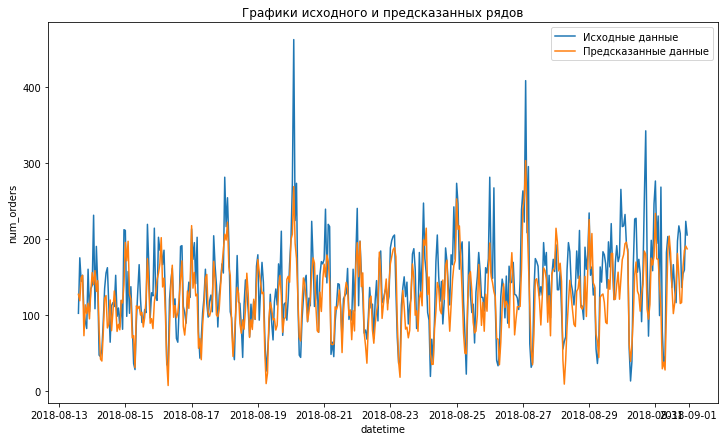

In [55]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=target_test)
sns.lineplot(x=target_test.index, y=lr_pred_test)
plt.title('Графики исходного и предсказанных рядов')
plt.legend(['Исходные данные', 'Предсказанные данные'])
plt.show()

<div style="border:solid orange 2px; padding: 20px"> 

## Вывод

В ходе работы над данным проектом были загружены и проанализированы предоставленные данные о заказах такси.\
Был проведен анализ на тренд и сезонность данных, в ходе которых выяснилось, что:
- Общий тренд идет на повышение количества заказов;
- Ближе к полуночи количество заказов увеличивается и достигает своего пика;
- К 6 утра же наоборот, кол-во заказов уменьшается, в связи с тем, что начинает
ходить общественный транспорт.

Далее были созданы дополнительные признаки для обучения на них.\
Данные были разделены на обучающую, валидационную и тестовую выборки, в соотношении 80:10:10.

Далее был обучен ряд моделей, таких как: LinearRegression, RandomForestRegressor, CatBoost, LightGBM.\
Были получены результаты на валидационных выборках:
- LinearRegression: 29.01
- RandomForestRegressor: 29.82
- CatBoost: 30.36
- LightGBM: 29.42

Лучший результат показала модель линейной регрессии, на ней и было проведено тестирование на тестовых данных. Был получен результат RMSE равный 39.29, что удовлетворяет поставленной задаче.